In [48]:
import numpy as np
import pandas as pd
from sklift.models import TwoModels
import lightgbm as lgb
from sklift import models, viz
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from matplotlib import pyplot as plt
import seaborn as sns
from sberav.splits.tests import ClassifierTwoSampleTestBootstrap, KolmogorovSmirnovTwoSamplesTest
from tqdm import tqdm

# Data

In [30]:
data_path = "../../data/preprocessed/"  # features_with_target.csv

transaction_features = pd.read_csv(data_path + "x5_transaction_features.csv", index_col="client_id")
client_features = pd.read_csv(data_path + "x5_client_features.csv", index_col="client_id")
df_target = pd.read_csv("../../data/datasets/x5-retail-hero/uplift_train.csv.gz", index_col="client_id")
df = transaction_features.join(client_features).join(df_target)
df

,regular_points_received_mean,regular_points_received_std,regular_points_received_median,regular_points_received_max,regular_points_received_skew,express_points_received_mean,express_points_received_std,express_points_received_median,express_points_received_max,express_points_received_skew,...,percent_of_transactions_in_12_month,age,first_issue_time,first_redeem_time,issue_redeem_delay,F,M,U,treatment_flg,target
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,6.425000,2.973529,6.85,10.0,-0.355890,0.000,0.000000,0.0,0.0,0.000000,...,2,45,0.336675,0.735365,0.398690,0,0,1,0,1
000036f903,1.715625,1.461401,1.30,7.0,2.367965,1.875,10.439558,0.0,60.0,5.388159,...,10,72,0.015925,0.033211,0.017286,1,0,0,1,1
00010925a5,1.766667,1.139688,1.45,5.8,2.321282,0.000,0.000000,0.0,0.0,0.000000,...,6,83,1.303876,1.428140,0.124264,0,0,1,1,1
0001f552b0,5.260000,9.686334,1.60,39.7,2.953750,0.000,0.000000,0.0,0.0,0.000000,...,4,33,0.238463,1.381198,1.142734,1,0,0,1,1
00020e7b18,15.894444,13.081389,14.60,44.5,0.819229,0.000,0.000000,0.0,0.0,0.000000,...,2,73,0.648549,0.751613,0.103064,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,2.466667,3.003701,0.70,7.3,0.703218,0.000,0.000000,0.0,0.0,0.000000,...,1,35,0.648236,0.838325,0.190090,1,0,0,0,0
fffe0ed719,2.330000,2.281542,1.50,8.6,1.531437,0.000,0.000000,0.0,0.0,0.000000,...,4,69,0.448229,0.671819,0.223590,0,0,1,0,1
fffea1204c,1.535294,1.710845,0.90,5.9,1.563107,0.000,0.000000,0.0,0.0,0.000000,...,4,73,0.827236,0.918646,0.091409,1,0,0,0,1


## Preprocessing


In [31]:
print("Number of entries where age is not defined:", df.age.le(0).sum())
df = df[df.age > 0]
print("Number of clients with age > 0:", df.shape[0])

print("Number of clients with age > 110:", df.age.gt(110).sum())
df = df[df.age < 110]
print("Number of clients with age from (0, 110):", df.shape[0])

Number of entries where age is not defined: 77
Number of clients with age > 0: 199962
Number of clients with age > 110: 514
Number of clients with age from (0, 110): 199448


In [32]:
def split_df(df, columns = None):
    features = df[df.columns.difference(['treatment_flg', 'target', 'client_id', 'gender'])]
    if columns is not None:
        features = features[columns]
    y_target = df.target
    treatment = df.treatment_flg
    
    return features, y_target, treatment

### Split

In [33]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8, stratify=df.treatment_flg, random_state=42)

# EDA

In [34]:
train_features, train_target, train_treatment = split_df(df_train)

In [35]:
train_features.columns

Index(['F', 'M', 'U', 'age', 'express_points_received_max',
       'express_points_received_mean', 'express_points_received_median',
       'express_points_received_skew', 'express_points_received_std',
       'express_points_spent_max', 'express_points_spent_mean',
       'express_points_spent_median', 'express_points_spent_skew',
       'express_points_spent_std', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay', 'percent_of_transactions_in_0_day',
       'percent_of_transactions_in_10_month',
       'percent_of_transactions_in_11_month',
       'percent_of_transactions_in_12_month',
       'percent_of_transactions_in_1_day',
       'percent_of_transactions_in_1_month',
       'percent_of_transactions_in_2_day',
       'percent_of_transactions_in_2_month',
       'percent_of_transactions_in_3_day',
       'percent_of_transactions_in_3_month',
       'percent_of_transactions_in_4_day',
       'percent_of_transactions_in_4_month',
       'percent_of_transactions_in_

In [36]:
print("Number of features:", train_features.shape[1])

Number of features: 51


In [37]:
pd.crosstab(df.treatment_flg, df.target, normalize=False)

target,0,1
treatment_flg,,
0,39558,60207
1,36215,63468


## Age of customers

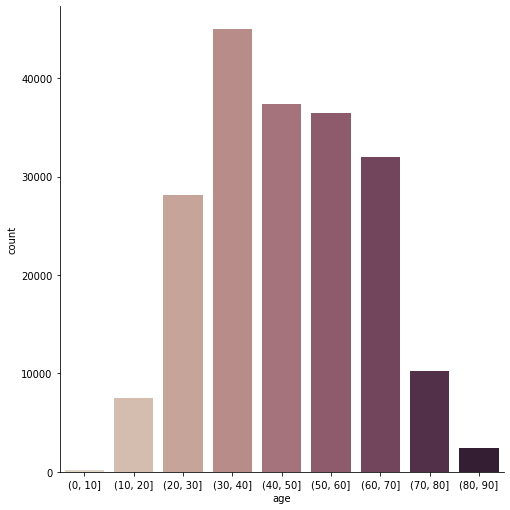

In [38]:
# fig, ax = plt.subplots(figsize=(10, 5))

g = sns.catplot(
    x="age",
    data=pd.cut(df.age, bins=list(range(0, 100, 10))).to_frame(),
    kind="count",
    palette="ch:.25",
    height=7
)

# Data quality

## Classifier two sample test

# Models

In [39]:
logs = dict()
models_dict = dict()

## Sklift models

## Two tower models

#### TwoTowerModel

In [40]:
treatment_model = lgb.LGBMClassifier()
control_model = lgb.LGBMClassifier()
models_dict['tt_lgb'] = TwoModels(treatment_model, control_model, )

#### TwoTowerModel + Logreg

In [41]:
logreg_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10_000))
models_dict['tt_logreg'] = TwoModels(clone(logreg_model), clone(logreg_model))

## Class Transformation models

#### Class Transformation + LGBM

In [42]:
models_dict['ct_lgbm'] = models.ClassTransformation(lgb.LGBMClassifier())

#### Class Transformation + LogReg

In [43]:
models_dict['ct_logreg'] = models.ClassTransformation(clone(logreg_model))

## Splits

In [46]:
features_train, y_train, treatment_train = split_df(df_train)
features_test, y_test, treatment_test = split_df(df_test)

## Train functions

In [58]:
def train_sklift(model, x, y, t):
    return model.fit(x, y, t)

def predict_sklift(model, x):
    return model.predict(x)

## Predict

In [72]:
from collections import defaultdict

from sklearn.model_selection import KFold


def cross_validate(model, train_fn, predict_fn, df, metrics: dict, **kfold_params):
    results = defaultdict(list)
    
    for train_index, test_index in KFold(**kfold_params).split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]
        train_tuple, test_tuple = split_df(train_df), split_df(test_df)
        model = train_fn(model, *train_tuple)
        prediction = predict_fn(model, test_tuple[0])
        
        for metric_name, metric_fn in metrics.items():
            results[metric_name].append(metric_fn(prediction, test_tuple))
            
    return results
        
    
metric_fns = {
    'uplift@30': lambda pred, test_tuple: metrics.uplift_at_k(test_tuple[1], pred, test_tuple[2], strategy="by_group", k = 0.3),
    'auuc': lambda pred, test_tuple: metrics.uplift_auc_score(test_tuple[1], pred, test_tuple[2]),
}

# cross_validate(models_dict['ct_lgbm'], train_sklift, predict_sklift, df, metric_fns)

### sklift

In [75]:
for model_name, model in tqdm(models_dict.items()):
    scores = cross_validate(model, train_sklift, predict_sklift, df, metric_fns)
    for metric_name, score in scores.items():
        print(f"{model_name} {metric_name}:", f"{np.mean(score):.5f}", "+-", f"{np.std(score):.5f}")

 25%|██▌       | 1/4 [00:16<00:49, 16.55s/it]

tt_lgb uplift@30: 0.06071 +- 0.00837
tt_lgb auuc: 0.01938 +- 0.00377


 50%|█████     | 2/4 [00:35<00:34, 17.17s/it]

tt_logreg uplift@30: 0.07088 +- 0.00914
tt_logreg auuc: 0.02297 +- 0.00641


/home/isabella/code/study/diploma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  
 75%|███████▌  | 3/4 [00:46<00:15, 15.43s/it]

ct_lgbm uplift@30: 0.07809 +- 0.01077
ct_lgbm auuc: 0.03181 +- 0.00398


/home/isabella/code/study/diploma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  
/home/isabella/code/study/diploma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  
/home/isabella/code/study/diploma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  
/home/isabella/code/study/diploma/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  
100%|██████████| 4/4 [00:59<00:00, 14.82s/it]

ct_logreg uplift@30: 0.06790 +- 0.00668
ct_logreg auuc: 0.02281 +- 0.00515


### Uplift curve

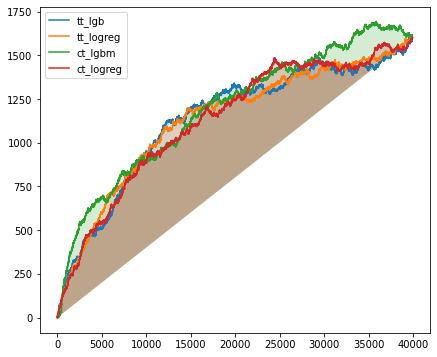

In [51]:
def plot_uplift_curve(target, uplift, treatment, ax, plot_kwargs, fillbetween_kwargs):
    x, y = viz.base.uplift_curve(target, uplift, treatment)
    y_baseline = x * y[-1] / len(target)
    ax.plot(x, y, **plot_kwargs)
    ax.fill_between(x, y, y_baseline, **fillbetween_kwargs)
    return ax


fig, ax = plt.subplots(figsize=(7, 6))
for model_name, prediction in predictions.items():
    plot_uplift_curve(y_test, prediction, treatment_test, ax, 
                      {'label': model_name}, 
                      {'alpha': 0.2})
ax.legend()

### Uplift@30

In [53]:
from sklift import metrics

for model_name, prediction in predictions.items():
    print(f"{model_name} Uplift@30:", metrics.uplift_at_k(y_test, prediction, treatment_test, strategy="by_group", k = 0.3))

tt_lgb Uplift@30: 0.08997447640167133
tt_logreg Uplift@30: 0.08912206951084456
ct_lgbm Uplift@30: 0.08280694491062413
ct_logreg Uplift@30: 0.08111140583443222


### AUUC

In [54]:
for model_name, prediction in predictions.items():
    print(f"{model_name} AUUC:", metrics.uplift_auc_score(y_test, prediction, treatment_test))

tt_lgb AUUC: 0.029983598787417676
tt_logreg AUUC: 0.03002137869213231
ct_lgbm AUUC: 0.03508407645198444
ct_logreg AUUC: 0.029547245038352824


# Model behaviour explaining